In [2]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ranuon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

text = "I love Python!"

scores = analyzer.polarity_scores(text)

print(scores)

{'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'compound': 0.6696}


In [4]:
import pandas as pd

file_path = 'script_merged.txt'

In [5]:
with open(file_path, 'r') as file:
    lines = file.readlines()

print(len(lines))

2524


In [6]:
cleaned_lines = []
for line in lines:
    parts = line.strip().split('" "')
    if len(parts) == 3:
        cleaned_lines.append(parts)

structured_data = pd.DataFrame(cleaned_lines, columns=["index", "character", "dialogue"])

structured_data.head()

structured_data

,index,character,dialogue
0,"""1",THREEPIO,Did you hear that? They've shut down the main...
1,"""2",THREEPIO,"We're doomed!"""
2,"""3",THREEPIO,There'll be no escape for the Princess this ti...
3,"""4",THREEPIO,"What's that?"""
4,"""5",THREEPIO,I should have known better than to trust the l...
...,...,...,...
2518,"""670",LANDO,"Wedge, I don't think we're going to make it."""
2519,"""671",WEDGE,"You'll make it. Just follow me Gold Leader."""
2520,"""672",LANDO,I promised to return his ship without a scratc...
2521,"""673",HAN,"Lando..."""


In [ ]:
from nltk.tokenize import sent_tokenize
import pandas as pd
nltk.download('punkt_tab')

### read dataframe somehow before
structured_data["sentences"] = structured_data["dialogue"].apply(sent_tokenize)
sentences = structured_data.drop(columns=['dialogue']).explode('sentences').reset_index().drop("index", axis=1)
character_sentence_counts = sentences['character'].value_counts()
top_10_percentile_threshold = character_sentence_counts.quantile(0.90)
top_10_percentile_characters = character_sentence_counts[character_sentence_counts >= top_10_percentile_threshold].index
print(top_10_percentile_characters)
# Index(['LUKE', 'HAN', 'THREEPIO', 'LEIA', 'VADER', 'BEN', 'LANDO', 'YODA',
#       'EMPEROR', 'BIGGS', 'CREATURE', 'TARKIN', 'RED LEADER'],
#      dtype='object', name='character')

# CREATURE AND YODA ARE THE SAME IN THE 3rd movie.
# If you check the data, there is another CREATURE in the script, but in the 3rd movie, we replace that convo.
sentences = sentences.drop([646, 647])

# Merge naming
sentences['character'] = sentences['character'].replace('CREATURE', 'YODA')
sentences.groupby("character").count().sort_values("sentences", ascending=False).head(20)
sentences[sentences["character"] == "YODA"].count()

# This is 215

[nltk_data] Downloading package punkt_tab to /home/ranuon/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Index(['LUKE', 'HAN', 'THREEPIO', 'LEIA', 'VADER', 'BEN', 'LANDO', 'YODA',
       'EMPEROR', 'BIGGS', 'TARKIN', 'CREATURE', 'RED LEADER'],
      dtype='object', name='character')


level_0      217
character    217
sentences    217
dtype: int64

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

sentences = sentences.assign(
    neutral=sentences["sentences"].apply(lambda sent: analyzer.polarity_scores(sent)["neu"]),
    negative=sentences["sentences"].apply(lambda sent: analyzer.polarity_scores(sent)["neg"]),
    positive=sentences["sentences"].apply(lambda sent: analyzer.polarity_scores(sent)["pos"]),
    compound=sentences["sentences"].apply(lambda sent: analyzer.polarity_scores(sent)["compound"])
)

sentences[sentences["character"].isin(top_10_percentile_characters)].groupby("character").mean("compound").sort_values("compound", ascending=True)
# RED LEADER has the lowest compound sentiment

,level_0,neutral,negative,positive,compound
character,,,,,
RED LEADER,947.018519,0.900519,0.083556,0.015926,-0.047180
TARKIN,501.586207,0.813241,0.106103,0.080655,-0.035371
VADER,1468.460870,0.805783,0.086817,0.107409,0.007430
LANDO,1959.631579,0.825140,0.082251,0.092602,0.019888
THREEPIO,1219.105008,0.849935,0.061519,0.088546,0.022871
LEIA,1399.991018,0.845665,0.067299,0.087045,0.027307
EMPEROR,2254.020833,0.703667,0.124125,0.172188,0.028696
LUKE,1082.222877,0.861058,0.053420,0.085526,0.030125
BEN,931.378995,0.840073,0.071571,0.088356,0.030460


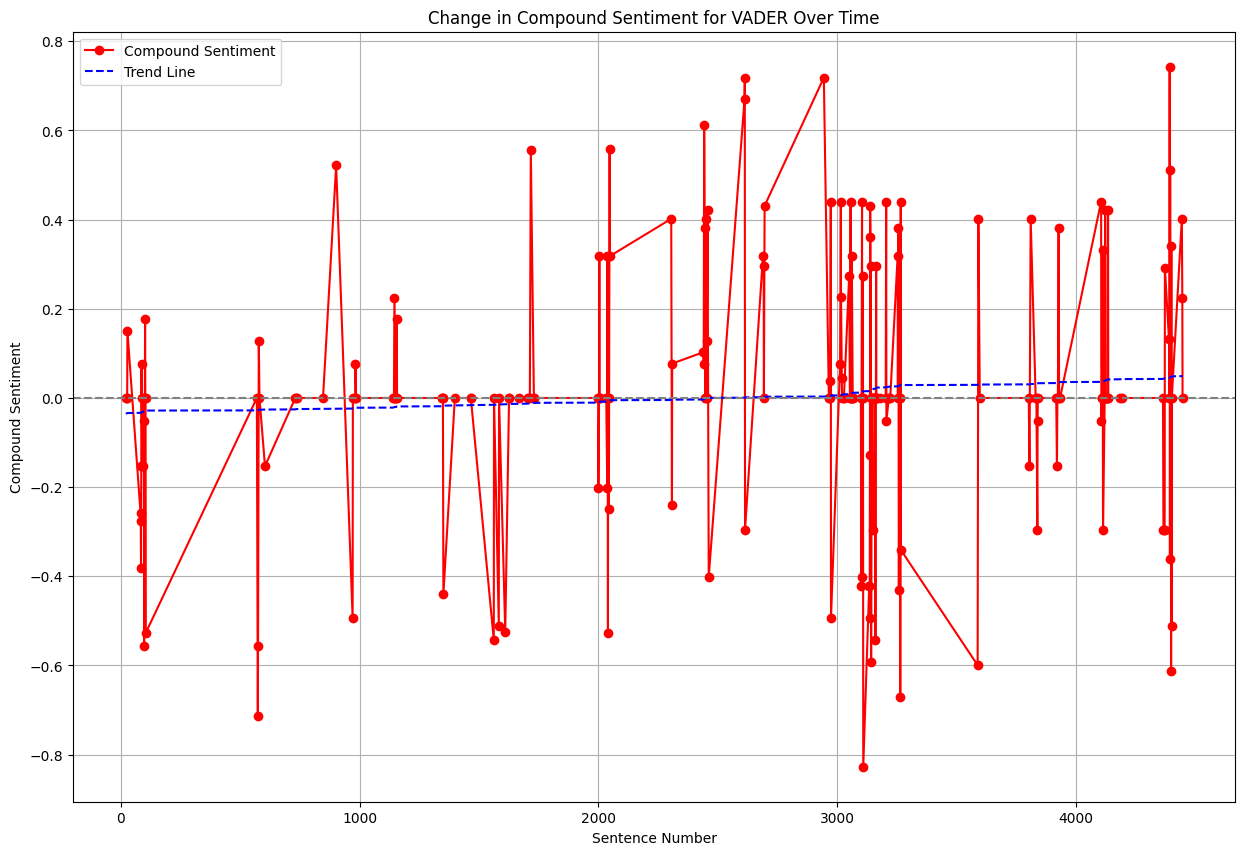

0.00036932007426786255


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'sentences' is your DataFrame with the relevant columns

# Step 1: Filter the DataFrame to include only rows where the character is "VADER"
vader_sentences = sentences[sentences['character'] == 'VADER']

# Step 2: Plot the compound sentiment values over the sequence of sentences
plt.figure(figsize=(15, 10))
plt.plot(vader_sentences.index, vader_sentences['compound'], marker='o', linestyle='-', color='red', label='Compound Sentiment')

# Step 3: Calculate the trend line
x = np.arange(len(vader_sentences))
y = vader_sentences['compound'].values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Step 4: Plot the trend line
plt.plot(vader_sentences.index, p(x), linestyle='--', color='blue', label='Trend Line')

# Step 5: Customize the plot
plt.title('Change in Compound Sentiment for VADER Over Time')
plt.xlabel('Sentence Number')
plt.ylabel('Compound Sentiment')
plt.axhline(0, color='gray', linestyle='--')  # Add a horizontal line at 0 to separate positive/negative sentiment
plt.legend()
plt.grid(True)

# Step 6: Display the plot
plt.show()

# Optional - if you would like numeric representation for this, you can extract the slope like this:
slope = z[0]
print(slope)
# 0.0005406942023232134 which is positive, so we can state that it is increasing
